In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import glob
from metpy.plots import ctables
import matplotlib.pyplot as plt

In [2]:
# header line one
#    Three-letter site identifier
#    Site latitude (degrees x 100)
#    Site longitude (degrees x 100)
#    Site altitude (m)
#    Operating frequency (Gigahertz x 10^5)

data_columns = ['Radial velocity (m/s)',
                'Signal-to-noise ratio (dB)',
                'Signal power (dB)',
                'Spectral width (m/s)',
                'Noise amplitude (dB)',
                'QC value']

In [3]:
file_list = glob.glob('/storage/dlhogan/synoptic_sublimation/splash_data/fmcw_raw/kps/*')

In [23]:
time_series = []
year='22'
date ='363'
if len([file for file in file_list if file[-11:-6] == year+date ]) != 0:
    for filepath in [file for file in file_list if file[-11:-6] == year+date ]:    
        data = np.genfromtxt(filepath, delimiter='\s+', dtype=str)
        range_gate_size = 252
        # number of rows in the data
        num_rows = len(data)

        # initialize a list 
        for i,start in enumerate(np.arange(3, num_rows, range_gate_size)):
            if i != len(np.arange(3, num_rows, range_gate_size))-1:
                if start == 3:
                    headers = 0
                    time_header = [float(x) for x in data[start-2].split()]
                    time_header_dict={'beam_index':time_header[0],
                                    'azimuth_angle':time_header[1],
                                    'elevation_angle':time_header[2],
                                    'year':time_header[3],
                                    'day_of_year':time_header[4],
                                    'hour':time_header[5],
                                    'minute':time_header[6],
                                    'second':time_header[7]}
                    pulse_header = [float(x) for x in data[start-1].split()]
                    pulse_header_dict={'inter_pulse_period':pulse_header[0],
                                    'pulse_width':pulse_header[1],
                                    'range_to_first_range_gate':pulse_header[2],
                                    'distance_between_range_gates':pulse_header[3],
                                    'number_of_range_gates':pulse_header[4],
                                    'number_of_coherent_integrations':pulse_header[5],
                                    'number_of_averaged_spectra':pulse_header[6],
                                    'number_of_FFT_points':pulse_header[7],
                                    'number_of_code_bits':pulse_header[8]}
                else:
                    headers = 2*i
                    time_header = [float(x) for x in data[start+headers-2].split()]
                    time_header_dict={'beam_index':time_header[0],
                                    'azimuth_angle':time_header[1],
                                    'elevation_angle':time_header[2],
                                    'year':time_header[3],
                                    'day_of_year':time_header[4],
                                    'hour':time_header[5],
                                    'minute':time_header[6],
                                    'second':time_header[7]}
                    pulse_header = [float(x) for x in data[start+headers-1].split()]
                    pulse_header_dict={'inter_pulse_period':pulse_header[0],
                                    'pulse_width':pulse_header[1],
                                    'range_to_first_range_gate':pulse_header[2],
                                    'distance_between_range_gates':pulse_header[3],
                                    'number_of_range_gates':pulse_header[4],
                                    'number_of_coherent_integrations':pulse_header[5],
                                    'number_of_averaged_spectra':pulse_header[6],
                                    'number_of_FFT_points':pulse_header[7],
                                    'number_of_code_bits':pulse_header[8]}
                
                offset = start + headers
                end = offset + range_gate_size 
                
                date_time = pd.to_datetime(time_header_dict['year'], format='%y') + pd.Timedelta(days=time_header_dict['day_of_year'], 
                                                                                                    hours=time_header_dict['hour'], 
                                                                                                    minutes=time_header_dict['minute'], 
                                                                                                    seconds=time_header_dict['second'])
                    
                range_gate = data[offset:end][0:200]
                range_dict = {}
                for i,row in enumerate(range_gate):
                    range_dict[(i+1)*40] = np.array([float(x) for x in row.split()])
                df = pd.DataFrame(range_dict).T
                # rename the columns
                df.columns = data_columns

                time_series.append({"time": {"dims":("time"), "data":np.array([pd.to_datetime(date_time)])}, 
                            data_columns[0]: {"dims":("time", "range_gate"), "data":np.reshape(df[data_columns[0]].values, (1,-1))}, 
                            data_columns[1]: {"dims":("time", "range_gate"), "data":np.reshape(df[data_columns[1]].values, (1,-1))},
                            data_columns[2]: {"dims":("time", "range_gate"), "data":np.reshape(df[data_columns[2]].values, (1,-1))},
                            data_columns[3]: {"dims":("time", "range_gate"), "data":np.reshape(df[data_columns[3]].values, (1,-1))},
                            data_columns[4]: {"dims":("time", "range_gate"), "data":np.reshape(df[data_columns[4]].values, (1,-1))},
                            data_columns[5]: {"dims":("time", "range_gate"), "data":np.reshape(df[data_columns[5]].values, (1,-1))}})
else:
    print('No files for this date')

No files for this date


In [15]:
da = xr.concat([xr.Dataset.from_dict(ts) for ts in time_series], dim='time')
da['range_gate'] = np.linspace(40, 8000, 200)
# 2723

In [16]:
# corrections to the data
# convert the noise amplitude values in raw file to standard units
da['NoiseAmpStd'] = 10**(da['Noise amplitude (dB)']/10)

In [17]:
NoisePowerAvg_list = []
da_subset = da['NoiseAmpStd'].isel(range_gate=slice(10, None))
fft_points = pulse_header_dict['number_of_FFT_points']
for time in da_subset.time:
    tmp_da = da_subset.sel(time=time)
    NoiseAmpStd = tmp_da.sortby(tmp_da, ascending=True).isel(range_gate=slice(0,5))
    # sum the noise power by multiplying by each of the 5 smallest noise amplitudes by the number of FFT points
    NoisePowerSum = (NoiseAmpStd * fft_points).sum(dim='range_gate')
    NoisePowerAvg = 10*np.log10(NoisePowerSum/5) 
    NoisePowerAvg_list.append(NoisePowerAvg)

In [18]:
da['NoisePowerAvg'] = xr.concat(NoisePowerAvg_list, dim='time')


In [19]:
# calculate range correced SNR for each range gate per profile

da['SnrRc'] = (da['Signal power (dB)'] - da['NoisePowerAvg'])  + (20 * np.log10(da.range_gate))

In [20]:
# creata a continuous colormap from the NWS reflectivity color table
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 5, 5)
# ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSVelocity', 10, 10)

Text(0, 0.5, 'Elevation (km asl)')

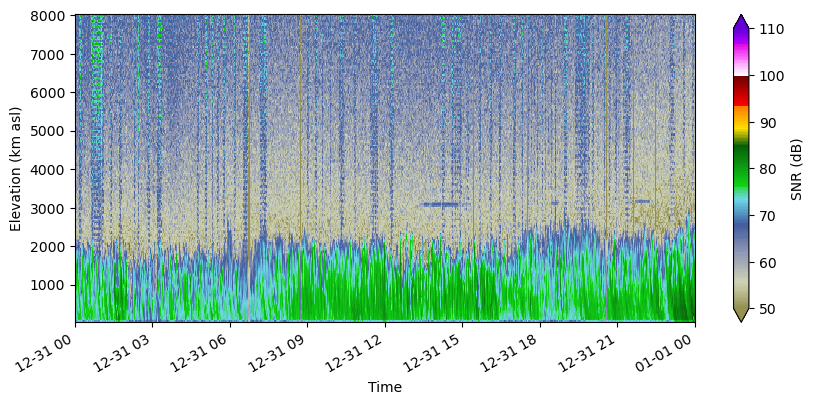

In [22]:
# replace range gate values with np.array([np.linspace(40, 400, 10)])
fig, ax = plt.subplots(figsize=(10,4))
((da['SnrRc'])).plot.imshow(x='time', y='range_gate', cmap=ref_cmap, vmin=50, vmax=110,
                                      cbar_kwargs={'label': 'SNR (dB)'},
                                      )

ax.set_xlabel('Time')   
ax.set_ylabel('Elevation (km asl)')

# Convert the y-axis from m to km
# ax.set_yticklabels(np.round(ax.get_yticks()/1000, 1))


In [3]:
ds = xr.open_dataset('./01_data/raw_data/sail_dec2022/ceilometer_10m_backscatter_20221221_20221227.nc')
ds_5min = ds.resample(time='5min').mean()

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


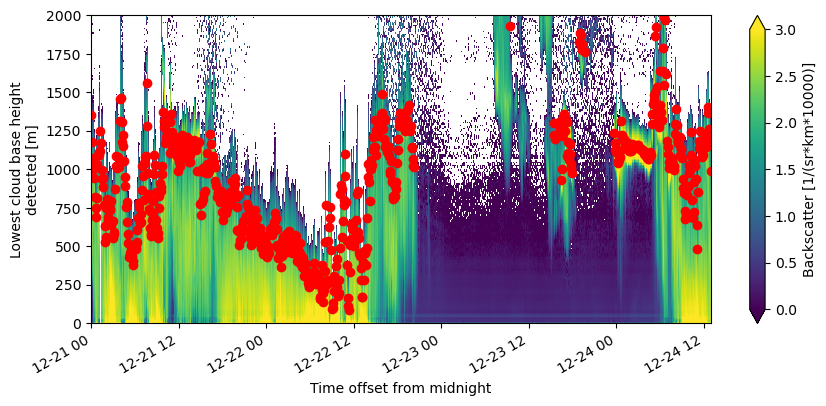

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
(np.log10(ds_5min['backscatter'])).sel(time=slice('2022-12-21 00','2022-12-24 12'), range=slice(5,2000)).plot(x='time', y='range', vmin=0, vmax=3, ax=ax)
ds_5min['first_cbh'].sel(time=slice('2022-12-21 00','2022-12-24 12')).plot.scatter(x='time', ax=ax, color='r')